TASK 1

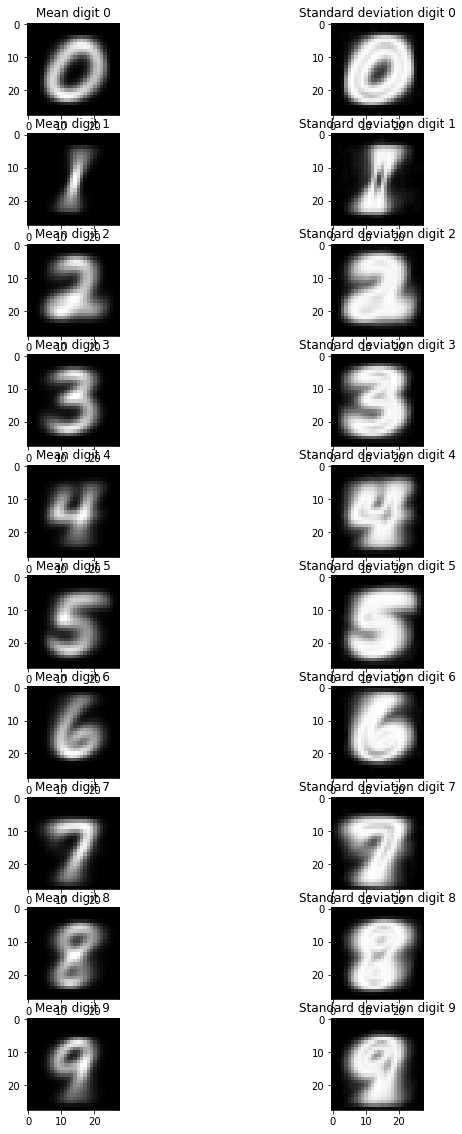

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist


class Mean_Standarddeviation:
    def __init__(self, num_cats=10):
        self.num_cats = num_cats
        self.mean_s = tf.Variable(tf.zeros((num_cats, 784)))
        self.std_s = tf.Variable(tf.zeros((num_cats, 784)))

    def compute_mean_standard_deviations(self, input_data, labels):
        input_data_flat = tf.reshape(input_data, (input_data.shape[0], -1))

        i = 0
        while i < self.num_cats:
            idx = tf.where(labels == i)
            mean = tf.reduce_sum(tf.gather(input_data_flat, idx), axis=0) / tf.cast(tf.shape(idx)[0], tf.float32)
            var = tf.reduce_sum(tf.math.squared_difference(tf.gather(input_data_flat, idx), mean), axis=0) / tf.cast(tf.shape(idx)[0], tf.float32)
            std = tf.sqrt(var)
            self.mean_s[i].assign(mean)
            self.std_s[i].assign(std)
            i += 1

        mean_plot = tf.reshape(self.mean_s, shape=[self.num_cats, 28, 28])
        std_plot = tf.reshape(self.std_s, shape=[self.num_cats, 28, 28])

        return mean_plot, std_plot
    
    def plot_mean_standard_deviation(self, input_data, labels):
        mean_plot, std_plot = self.compute_mean_standard_deviations(input_data, labels)

        fig, axs = plt.subplots(self.num_cats, 2, figsize=(10, 20))
        i = 0
        while i < self.num_cats:
            axs[i, 0].imshow(mean_plot[i], cmap='gray')
            axs[i, 0].set_title(f"Mean digit {i}")
            axs[i, 1].imshow(std_plot[i], cmap='gray')
            axs[i, 1].set_title(f"Standard deviation digit {i}")
            i += 1
        plt.show()


if __name__ == "__main__":
    # Load the MNIST dataset
    (train_data, train_labels), _ = mnist.load_data()
    train_data = train_data.astype('float32') / 255.0

    # Create a MeanStdPlotter instance and plot the mean and standard deviation images
    plotter = Mean_Standarddeviation()
    plotter.plot_mean_standard_deviation(train_data, train_labels)


TASK 2

In [16]:
import math
from collections import Counter
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Load MNIST dataset and split into training and testing sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

class GaussianNaiveBayes:
    def init(self):
        self.classes = None
        self.class_prior = None
        self.class_mean = None
        self.class_std = None
    
    def fit(self, X, y):
        self.classes = list(set(y))
        num_classes = len(self.classes)
        num_features = X.shape[1]
        
        # calculate class prior probabilities
        self.class_prior = {}
        for c in self.classes:
            self.class_prior[c] = (y == c).mean()
            
        # calculate class mean and standard deviation for each feature
        self.class_mean = {}
        self.class_std = {}
        for c in self.classes:
            X_c = X[y == c]
            self.class_mean[c] = X_c.mean(axis=0)
            self.class_std[c] = X_c.std(axis=0)
        
    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = self.class_prior[c]
                likelihood = 1.0
                for feature in range(len(x)):
                    mean = self.class_mean[c][feature]
                    std = self.class_std[c][feature]
                    likelihood *= self.gaussian_pdf(x[feature], mean, std)
                posterior = prior * likelihood
                posteriors.append(posterior)
            y_pred.append(self.classes[posteriors.index(max(posteriors))])
        return y_pred
    
    def gaussian_pdf(self, x, mean, std):
        return (1.0 / (math.sqrt(2 * math.pi) * std)) * math.exp(-0.5 * ((x - mean) / std) ** 2)


# create GaussianNaiveBayes object
clf = GaussianNaiveBayes()

# train the model
clf.fit(X_train, y_train)

# make predictions on the testing set
y_pred_test = clf.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
cm_test = confusion_matrix(y_test, y_pred_test)
print("Classification accuracy on testing set:", accuracy_test)
print("Confusion matrix on testing set:")
print(cm_test)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  0   1   2   3   4   5   6   7   8   9  10  11  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  52  53  54  55  56  57  82  83
  84  85 111 112 140 141 168 476 560 644 645 671 672 673 699 700 701 727
 728 729 730 754 755 756 757 758 759 780 781 782 783] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


Classification accuracy on testing set: 0.7259
Confusion matrix on testing set:
[[ 893    0    2    1    0   13   61    1    9    0]
 [   0 1083    5    5    0    1    0    0   41    0]
 [   8  138  665    9   15   18   56   20  100    3]
 [  14   60   29  751    5   56    9   19   39   28]
 [   3    2   10    4  389    2   74    9   16  473]
 [  27   20   14  152   19  473   33   29   31   94]
 [  39   15   15    1   30   23  688    5  127   15]
 [   7   39   46    0   19    2    4  829   20   62]
 [   5   81   15    7    5   33   54   10  712   52]
 [   4    9    5   14  111   12   32   27   19  776]]


On the MNIST dataset, the 0-1 loss function and Bayesian Decision Rule approach with the Gaussian distribution assumption do not perform well because they make a number of assumptions about the data that are not true in reality. For example, they assume that the class-conditional distribution of the image vector is Gaussian and that the covariance of the Gaussian distribution is the same for all classes. Moreover, the MNIST dataset may not be suitable for the 0-1 loss function because it is too strict. These approaches have been demonstrated to be inferior to other techniques, such as deep neural networks and convolutional neural networks, which capture non-linear correlations between features and labels without making firm assumptions about the underlying distribution of the data. These methods can also be trained with more sophisticated loss functions that better capture the nuances of the classification task.

TASK 3

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Loading the dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshaping the data
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)


In [6]:
model = tf.keras.Sequential([    tf.keras.layers.Dense(10, input_shape=(784,), activation='softmax')])

In [7]:
# Compile the model
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [8]:
# Train the model
model_train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=128)

Epoch 1/20
469/469 [==============================] - 2s 2ms/step - loss: 218.9401 - accuracy: 0.8269 - val_loss: 106.6108 - val_accuracy: 0.8807
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 143.3867 - accuracy: 0.8617 - val_loss: 109.5363 - val_accuracy: 0.8908
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 140.0127 - accuracy: 0.8697 - val_loss: 117.8329 - val_accuracy: 0.8824
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 117.6301 - accuracy: 0.8750 - val_loss: 154.8948 - val_accuracy: 0.8452
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 128.0369 - accuracy: 0.8714 - val_loss: 101.1300 - val_accuracy: 0.8938
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 121.8713 - accuracy: 0.8774 - val_loss: 90.7178 - val_accuracy: 0.9027
Epoch 7/20
469/469 [==============================] - 1s 3ms/step - loss: 121.0838 - accuracy: 0.8795 - val_loss: 101.4672 - 

In [9]:
loss, accuracy = model.evaluate(X_test, y_test)#evaluatimng the model
print('Test accuracy:', accuracy)
print('Test loss:', loss)
#prediction
y_pred = model.predict(X_test)
y_prediction = tf.argmax(y_pred, axis=1)


313/313 [==============================] - 0s 1ms/step - loss: 309.9581 - accuracy: 0.8297
Test accuracy: 0.8296999931335449
Test loss: 309.9581298828125
313/313 [==============================] - 0s 1ms/step


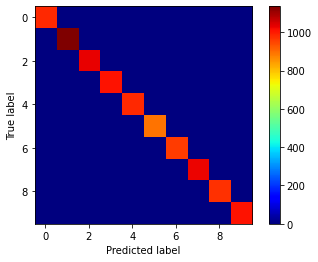

In [10]:
#Calculating the confusion matrix
confu_mtx = confusion_matrix(y_test, y_test)
# Displaying the confusion matrix
plt.imshow(confu_mtx, cmap='jet')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Label: 0
Images that are correctly classified: 938
Images which are Incorrectly classified: 42



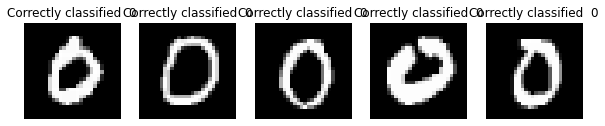

Label: 1
Images that are correctly classified: 1105
Images which are Incorrectly classified: 30



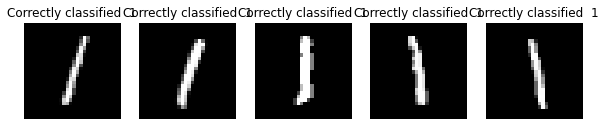

Label: 2
Images that are correctly classified: 947
Images which are Incorrectly classified: 85



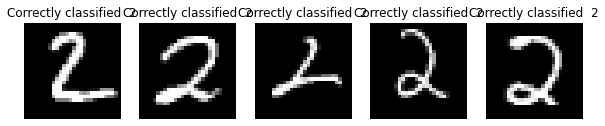

Label: 3
Images that are correctly classified: 919
Images which are Incorrectly classified: 91



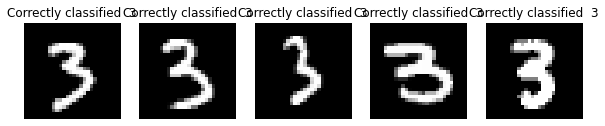

Label: 4
Images that are correctly classified: 922
Images which are Incorrectly classified: 60



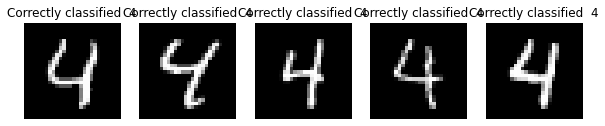

Label: 5
Images that are correctly classified: 735
Images which are Incorrectly classified: 157



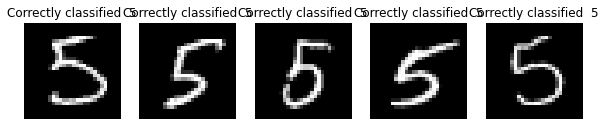

Label: 6
Images that are correctly classified: 917
Images which are Incorrectly classified: 41



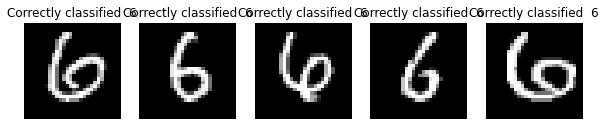

Label: 7
Images that are correctly classified: 981
Images which are Incorrectly classified: 47



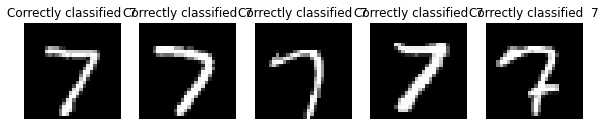

Label: 8
Images that are correctly classified: 817
Images which are Incorrectly classified: 157



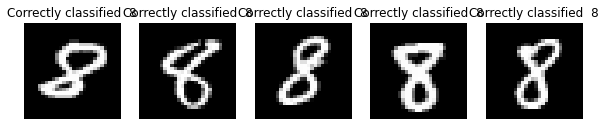

Label: 9
Images that are correctly classified: 16
Images which are Incorrectly classified: 993



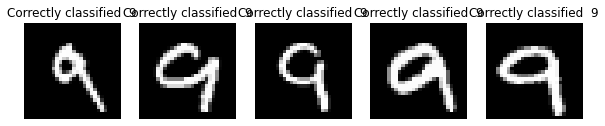

In [11]:
i = 0
while i < 10:
    correct_labels = []
    incorrect_labels = []
    for idx in range(len(y_test)):
        if y_test[idx] == i and y_prediction[idx] == i:
            correct_labels.append(idx)
        elif y_test[idx] == i and y_prediction[idx] != i:
            incorrect_labels.append(idx)
    print(f'Label: {i}')
    print(f'Images that are correctly classified: {len(correct_labels)}')
    print(f'Images which are Incorrectly classified: {len(incorrect_labels)}')
    print()
    fig, axes = plt.subplots(1, 5, figsize=(10, 5))
    j = 0
    while j < 5:
        if j < len(correct_labels):
            idx = correct_labels[j]
            heading = f'Correctly classified  {i}'
        elif j < len(correct_labels) + len(incorrect_labels):
            idx = incorrect_labels[j-len(correct_labels)]
            heading = f'Incorrectly classified {y_prediction[idx]}'
        else:
            break
        ax = axes[j]
        ax.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        ax.set_title(heading)
        ax.axis('off')
        j += 1
    plt.show()
    i += 1


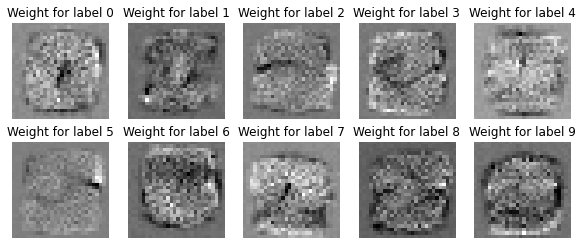

In [12]:
# To Display the weights as 28 x 28 images
weights = model.get_weights()[0].T
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(weights[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Weight for label {i}')
    ax.axis('off')
plt.show()

